# Experimental Design

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

Experimental design is the process in which we carry out research in an objective and controlled fashion. The purpose of this is to ensure we can make specific conclusions in reference to a hypothesis we have.

https://www.sciencedirect.com/topics/earth-and-planetary-sciences/experimental-design

Because we use objective tools, we need to use quantified language. Instead of using words like 'probably', 'likely', and 'small' when noting our conclusions, we should use precise and quantified language. This often takes the form of noting the percentage risk on a Type I error in the conclusion. 

Type I errors: we incorrectly reject the null hypothesis when it is actually true. 

## Terminology

**Subjects**
: What we are experimenting on

**Treatment**
: Some change given to one group

**Control group**
: The group not given any treatment

## How to assign subjects to groups

- Non Random (iloc with a range for instance)

In [ ]:
df = pd.read_feather('../data/dem_votes_potus_12_16.feather')

group1 = df.iloc[0:100]
group2 = df.iloc[100:200]


In [ ]:
group1.describe()

In [ ]:
group2.describe()

- Random (sample method for instance)

In [ ]:
random_group1 = df.sample(frac=0.5)
random_group1.describe()

In [ ]:
random_group2 = df.drop(random_group1.index)

In [ ]:
compare_df_rand = pd.concat([random_group1['dem_percent_12'].describe(), random_group2['dem_percent_12'].describe()], axis=1)
compare_df_rand.columns = ['group1', 'group2']

print(compare_df_rand)

# Experimental data setup

Randomization is often the best technique for setting up experimental data, but it isnt always.

## Scenarios where randomization could cause undesiderable outcomes

### Uneven issue

Different number of subjects in groups. Can be solved with block randomization.

### Covariates

Covariates are variables that potentially affect experiment results but aren't the primary focus. If covariates are highly variable or not equally distributed among groups, randomization might not produce balanced groups. This imbalance can lead to biased results. Overall these make it harder to see an effect from a treatment, as these issues may be driving an observed change.

In [ ]:
group1 = df.sample(frac=0.5, replace=False)
group1['Block']=1

group2 = df.drop(group1.index)
group2['Block']=2

print(len(group1), len(group2))

But does this technique eliminates the covariate issue?

A nice way of checking for potential covariate issues is with visualizations.

In [ ]:
sns.displot(data=df, x='dem_percent_12', fill=True, kind='kde'
            # , hue=''
           )

Not with this dataset, but it could happen that based on a second feature, there is quite a difference in the group distributions. When an effect could be because of a variable rather than the treatment, this is often called **confounding**. The covariate issue can be solved with stratified randomization.

### Stratified randomization

Stratified randomization involves splitting based on a potentially confounding variable first, followed by randomization


# Normal Data

Normal data is drawn from a normal distribution

The normal distribution is related to z-scores

$$z = \frac{ x - \mu}{ \sigma }$$

The most common normal distribution is the standard one, having $\mu$=0 and $\sigma$=0

The normal distribution is behind many of the statistical **parametric** tests. There are also# **non parametric** tests that dont assume normal data.

To visually check if a dataset follow a normal distribution we can plot the kde

Another visual tool are the qqplots, that compare 

In [ ]:
df = pd.read_csv('../data/chick_weight.csv')

df.info()

In [ ]:
n_rows=2
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])


In [ ]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm

In [ ]:
qqplot(data=df.weight, line='s')
plt.show()

In [ ]:
qqplot(df['weight'], 
       line='s', 
       dist=norm
      ) 
plt.show()

In [ ]:
# Subset the data
subset_data = df[df['Time'] == 2]

# Repeat the plotting
sns.displot(data=df, x='weight', kind="kde")
plt.show()

- ideally, the dots should follow the line
- bad: bow out at the ends

Other tests for normality: 
- Shapiro-Wilk: good for smaller datasets
- D'Agostino $K^2$ (uses curtosis and skewness
- Anderson-Darling returns a list of values

For all these, the $H<sub>0</sub>$ is "data is drawn from a Normal distribution"

# A Shapiro Wilk test
from scipy.stats import shapiro

alpha = 0.05
stat, p = shapiro(df.weight)
print(f'p:{round(p,4)} test stat: {round(stat, 4)}')


In [ ]:
# A Anderson Darling test
from scipy.stats import anderson

alpha = 0.05
result = anderson(x = df.weight, dist="norm")
print(round(result.statistic,4))
print(result.significance_level)
print(result.critical_values)

# Factorial Design

Factorial designs study multiple independent variables/factors in one experiment

They test every combination of factor levels. It discovers direct effects and interactions between factors


In [ ]:
marketing_data = pd.read_feather('../data/marketing_data.feather')

In [ ]:
# Create a pivot table for marketing campaign data
marketing_pivot = marketing_data.pivot_table(
  values='Conversions', 
  index='Messaging_Style', 
  columns='Time_of_Day', 
  aggfunc='mean')

# View the pivoted results
print(marketing_pivot)

In [ ]:
# Visualize interactions with a heatmap
sns.heatmap(marketing_pivot, 
         annot=True, 
         cmap='coolwarm',
         fmt='g')

plt.show()

The biggest change is registered in the evening messages from casual to formal.

### Factorial designs
- Multiple treatments and interactions
- Dissect complex multi variable effects and interactions
- Can require more subjects

### Block Designs
- Group similar subjects in randomized designs
- Control within-block variance
- Each treatment is tested within every block

# Randomized block design

Blocking involves grouping experimental units, often with similar characteristics, to minimize variance within these groups
Each block, representing a specific level of the blocking factor, receives every treatment. 

In [ ]:
athletes = pd.read_csv('../data/athletic_perf.csv')
athletes

To implement a randomized block design, we'll group the rows into blocks based on an initial feature, shuffle the rows within these blocks, and randomly assign a treatment.

In [ ]:
blocks = athletes.groupby('Initial_Fitness').apply(
    # Lets shuffle each block
    lambda x:x.sample(frac=1)
)
blocks = blocks.reset_index(drop=True)
blocks

In [ ]:
# Now, within each block, we assign exercise program randomly
blocks['Treatment'] = np.random.choice(
    ['Cardio', 'Strength Training', 'Mixed'], 
    size=len(blocks)
)

blocks.head()

In [ ]:
# A boxplot is an effective tool for visualizing the distribution of treatment effects across different blocks 

sns.boxplot(x='Initial_Fitness', y='Performance_Inc', hue='Treatment', data=blocks)

We can use ANOVA to statistically check for these differences.

In [ ]:
alpha=0.05

from scipy.stats import f_oneway

blocks.groupby("Initial_Fitness").apply(
    lambda x: f_oneway(x[x['Treatment']== 'Cardio']['Performance_Inc'],
                       x[x['Treatment']== 'Mixed']['Performance_Inc'], 
                       x[x['Treatment']== 'Strength Training']['Performance_Inc'], 
                      )
)

# Covariate adjustment in experimental design

Covariates are variables that are not of primary interest but are related to the outcome variable and can influence its analysis. Including covariates in statistical analyses is crucial for reducing confounding, which occurs when an external variable influences both the dependent variable and independent variable(s).

By adjusting for covariates researchers can isolate the effect of the independent variable on the outcome, minimizing the influence of confounders.

Like that, the analysis better reflects the true effect by isolating it from the influence of covariates.



In [ ]:
exp_chick_data = pd.read_csv('../data/chick_weight.csv')
cov_chick_data = pd.read_csv('../data/chick_cov.csv')


In [ ]:
exp_chick_data

In [ ]:
# Perform ANCOVA with Diet and Time as predictors
model = ols('weight ~ Diet + Time', data=exp_chick_data).fit()

# Print a summary of the model
print(model.summary())

Prob (F-statistic): The first portion of summary output provides details on the significance of the model; it shows a very small p-value, supporting for covariates affecting the model.
Large p-values would implie a lack of support for covariates affecting the model.

P>|t| of the second portion are very small, sugesting that each of them alone are significant predictors of growth for this model.

In [ ]:
# Visualize Diet effects with Time adjustment
sns.lmplot(x='Time', y='weight', 
         hue='Diet', 
         data=exp_chick_data)
plt.show()

The crossing lines here suggest we may add a The crossing regression lines suggest we may want to add an interaction term of time by Diet in another model. Parallel lines would suggest a lack of interaction.

# Choosing the right statistical test

Prior to choosing the right test, we have to pay attention to:
- Dataset Features:
  - Data types
  - Distributions: often assumed to be normal in many tests
  - Number of variables
- Hypothesis

Result: Accurate and dependable conclusions

Lets see how to apply t-tests, ANOVA and $\chi^2$

The athletic performance dataset contains the impact of training programs and diet on athletic performance

In [ ]:
athletic_perf = pd.read_csv('../data/athletic_perf.csv')
athletic_perf.head()

## Independent Samples t-test

Compares the means of two groups.
It assumes normal distributions and equal variances to ensure the reliability and validity of the test results.


In [ ]:
from scipy.stats import ttest_ind

group1 = athletic_perf[athletic_perf.Training_Program == 'HIIT']['Performance_Inc']
group2 = athletic_perf[athletic_perf.Training_Program == 'Endurance']['Performance_Inc']

t_stat, p_val = ttest_ind(group1, group2) 
print (f't_stat: {t_stat}, p-value: {p_val}')

> p_val > $\alpha$ -> insufficient evidence of a difference in means

## One Way ANOVA

Compares the means across multiple groups (more than 2)

Assumptions: equal variances among the groups

In [ ]:
from scipy.stats import f_oneway

program_types = ['HIIT', 'Endurance', 'Strength']

groups = [athletic_perf[athletic_perf['Training_Program'] == program]['Performance_Inc']
          for program in program_types]

f_stat, p_val = f_oneway(*groups)

print(f'F-statistic: {f_stat}, p_val: {p_val}')

> p_val > $\alpha$ -> insufficient evidence of a difference in means

## $\chi^2$ test of association

Tests relationships between categorical values.

It does not make assumtions about distributions of the data

To prepare for the test, we print the crosstab by training program and diet_type

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(athletic_perf['Training_Program'], 
                               athletic_perf['Diet_Type'])

contingency_table

In [ ]:
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f'chi2 statistic: {chi2_stat}, p_value: {p_val}')

> p_val > $\alpha$ -> insufficient evidence of an association

## Post-hoc analysis following ANOVA

Post-hoc tests are pivotal when ANOVA reveals significant differences among groups. 

Allows to explore pairwise group differences

2 Main post-hoc methods:

- Tukey's HSD: robust for multiple comparisons. Besto for broader comparisons
- Bonferroni correction: adjusts p-values to control for type I errors. Best for focused tests.

Pandas pivot_table() method is very helpful when preparing the data for a post_hoc analysis

In [ ]:
therapy_outcomes = pd.read_csv('../data/therapy_outcomes.csv', index_col=0)
therapy_outcomes

In [ ]:
# Pivot to view the mean anxiety reduction for each therapy
pivot_table = therapy_outcomes.pivot_table(
    values='Anxiety_Reduction', 
    index='Therapy_Type', 
    aggfunc="mean")
print(pivot_table)

# Create groups to prepare the data for ANOVA
therapy_types = ['CBT', 'DBT', 'ACT']
groups = [therapy_outcomes[therapy_outcomes['Therapy_Type'] == therapy]['Anxiety_Reduction'] for therapy in therapy_types]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

If ANOVA indicates significant differences, tukeys HSD test helps understanding exactly which values differ.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    therapy_outcomes['Anxiety_Reduction'], 
    therapy_outcomes['Therapy_Type'], 
    alpha=0.05
)

print(tukey_results)

In [ ]:
therapy_outcomes.Therapy_Type.value_counts()

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [ ]:
p_values = []

therapy_pairs = [('CBT', 'DBT'), ('CBT', 'ACT'), ('DBT', 'ACT')]

# Conduct t-tests and collect P-values
for pair in therapy_pairs:
    group1 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[0]]['Anxiety_Reduction']
    group2 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[1]]['Anxiety_Reduction']
    t_stat, p_val = ttest_ind(group1, group2)
    p_values.append(p_val)

# Apply Bonferroni correction
print(multipletests(p_values, alpha=0.05, method='bonferroni')[1])

# P-values, alpha, and errors

P-values are the probability of observing our data if the null hypothesis was true

$\alpha$ is the threshold at which we consider our results statistically significant. It indicates the probability of a type I error.

If p-value $\le$ $\alpha$ -> reject null hypothesis in favor of alternative hypothesis 

Common values for $\alpha$ are 0.1 (when higher tolerance for type I errors), 0.05 (most common), 0.01 (when the cost of a type I error is high), representing 10%, 5% and 1% risks of making a type I error.P-values are the probability of observing our data if the null hypothesis was true

Choosing an $\alpha$ depends on the context of the study and balances the tolerance for a type I error.

In [ ]:
toy_durability=pd.read_csv('../data/toy_durability.csv')
toy_durability

In [ ]:
toy_durability.Toy_Type.value_counts()

In [ ]:
# Calculate mean Durability_Score for each Toy_Type
mean_durability = toy_durability.pivot_table(
  values='Durability_Score', index='Toy_Type', aggfunc=np.mean)
print(mean_durability)

# Perform t-test
educational_durability = toy_durability[toy_durability['Toy_Type'] == 'Educational']['Durability_Score']
recreational_durability = toy_durability[toy_durability['Toy_Type'] == 'Recreational']['Durability_Score']
t_stat, p_val = ttest_ind(educational_durability, recreational_durability)

print(p_val)

In [ ]:
# Visualize the distribution of Durability_Score for each Toy_Type
sns.displot(data=toy_durability, x="Durability_Score", 
         hue="Toy_Type", kind="kde")
plt.title('Durability Score Distribution by Toy Type')
plt.xlabel('Durability Score')
plt.ylabel('Density')
plt.show()

## Power Analysis: sample and effect size

**Effect size** quantifies the difference between two groups. Cohen's d is a standard measure for effect size.

**Power** the probability of correctly rejecting a false null hypothesis: (1-$\beta$) where $\beta$ is the probability of a type II error


This high power tells us the likelihood that our test will detect a significant result, given our effect size and sample size.

In [ ]:
from statsmodels.stats.power import TTestIndPower

power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=1, nobs1=30, alpha=0.05)

print(power)

In [ ]:
TO REVIEW

In [ ]:
# Instantiate a TTestIndPower object
power_analysis = TTestIndPower()

# Conduct a power analysis to determine the required sample size
required_n = power_analysis.solve_power(
    effect_size=0.5, 
    alpha=0.05, 
    power=0.9, 
    ratio=1)

print(required_n)

We've determined that approximately 85 participants are required in each group to achieve a power of 0.9, assuming an Cohen's d effect size of 0.5. 

## How to synthesize insights from complex experiments

Graphs are a helpful tool for this purpose. They should be adapted depending on the audience.

Technical audiences prefer data narratives including p-values, test statistics and significance levels in it. Charts can be advanced like heat maps or scatter plots with multiple colors and projection lines.

A less technical audience prefers simplified data insights, basic graphs, content-centric presentations, with real world applications, and personalized reasons of why that matters.

In [68]:
loan_approval_yield = pd.read_csv('../data/loan_approval_yield.csv')
customer_satisfaction = pd.read_csv('../data/customer_satisfaction.csv')

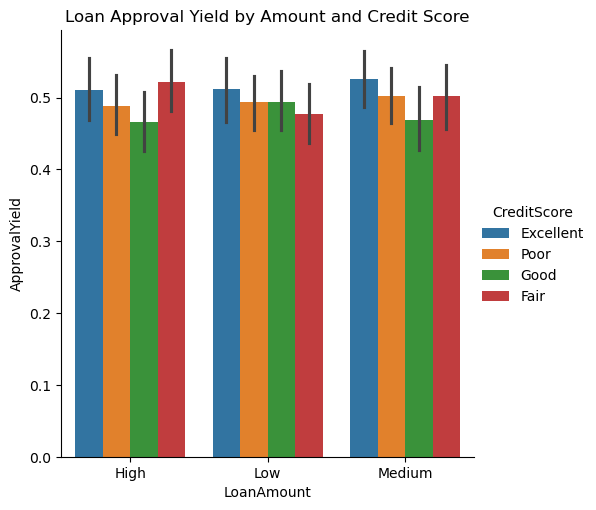

In [69]:
# Use Seaborn to create the bar graph
sns.catplot(x="LoanAmount", 
            y="ApprovalYield", 
            hue="CreditScore", 
            kind="bar", 
            data=loan_approval_yield)
plt.title("Loan Approval Yield by Amount and Credit Score")
plt.show()

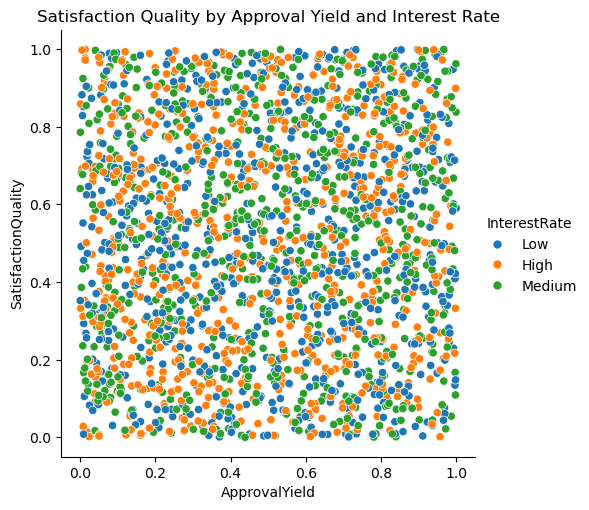

In [70]:
# Merge the two datasets
merged_data = pd.merge(loan_approval_yield, 
                       customer_satisfaction, 
                       on='ApplicationID')

# Use Seaborn to create the scatter plot
sns.relplot(y="SatisfactionQuality", 
            x="ApprovalYield", 
            hue="InterestRate", 
            kind="scatter", 
            data=merged_data)
plt.title("Satisfaction Quality by Approval Yield and Interest Rate")
plt.show()

## Addresing complexities in experimental data

Heteroscedasticity: changing variability of a variable across a range of another variable. The sns .residplot() method with the lowess=True can help us identifying this.

When the residual plots deviates from expectations, its interesting to check the distribution of the variables used (distplot()). To address issues like skewness and heteroscedasticity, we can apply data transformations like Box-Cox



Confounding variables

In [79]:
food_preservation = pd.read_csv('../data/food_preservation.csv')

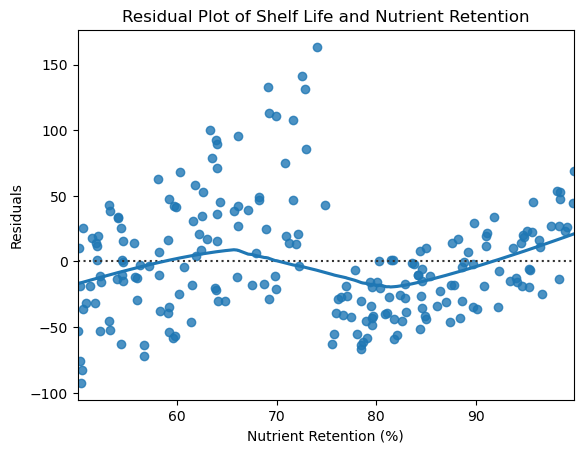

In [80]:
# Check for heteroscedasticity with a residual plot
sns.residplot(x='NutrientRetention', y='ShelfLife', 
         data=food_preservation, lowess=True)
plt.title('Residual Plot of Shelf Life and Nutrient Retention')
plt.xlabel('Nutrient Retention (%)')
plt.ylabel('Residuals')
plt.show()

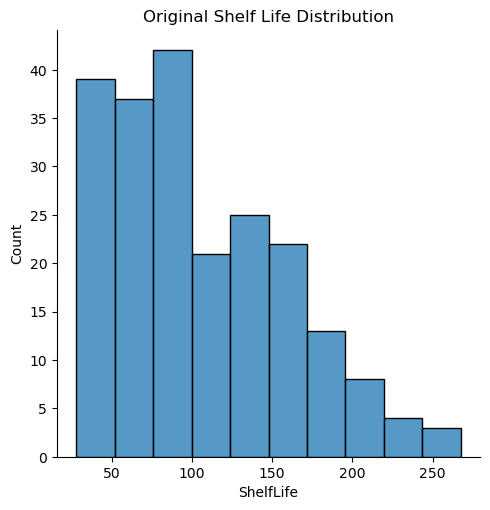

<Figure size 640x480 with 0 Axes>

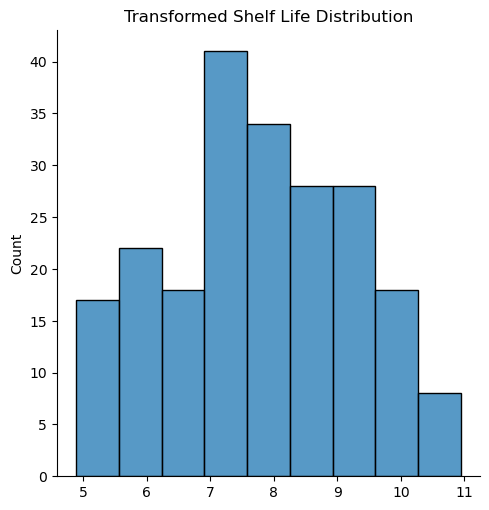

In [82]:
from scipy.stats import boxcox

# Visualize the original ShelfLife distribution
sns.displot(food_preservation['ShelfLife'])
plt.title('Original Shelf Life Distribution')
plt.show()

# Create a Box-Cox transformation
ShelfLifeTransformed, _ = boxcox(food_preservation['ShelfLife'])

# Visualize the transformed ShelfLife distribution
plt.clf()
sns.displot(ShelfLifeTransformed)
plt.title('Transformed Shelf Life Distribution')
plt.show()

## Applying nonparametric tests in experimental analysis

When:
- Parametric test assumption are not met
- Or data on ordinal scale or non normal
- Need robustness against outliers or non linear data

Visualizing nonparametric data can reval underlying patterns. Violin plots can help here. Boxen plots, an extension of box plots, display more information and gives more insight into the distribution shape.


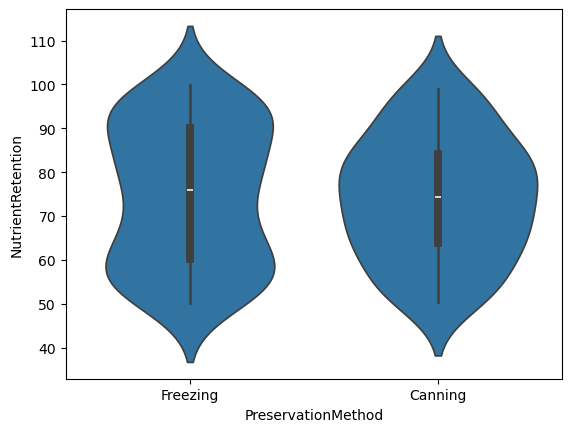

NameError: name 'mannwhitneyu' is not defined

In [83]:
from scipy.stats import mannwhitneyu

# Filter to Freezing and Canning data
condensed_food_data = food_preservation[food_preservation['PreservationMethod'].isin(['Freezing', 'Canning'])]

# Create a violin plot for nutrient retention by preservation method
sns.violinplot(data=condensed_food_data, 
               x="PreservationMethod", 
               y="NutrientRetention")
plt.show()

# Separate nutrient retention for Freezing and Canning methods
freezing = food_preservation[food_preservation['PreservationMethod'] == 'Freezing']['NutrientRetention']
canning = food_preservation[food_preservation['PreservationMethod'] == 'Canning']['NutrientRetention']

# Perform Mann Whitney U test
u_stat, p_val = mannwhitneyu(freezing, canning)

# Print the p-value
print("Mann Whitney U test p-value:", p_val)